In [0]:
# Pronóstico de la evolución de pacientes con diabetes

## Descripción del problema real

Los tratamientos médicos están basados en las expectativas de recuperación o el avance de una enfermedad para tomar decisiones. En este caso, un equipo médico desea contar con pronósticos de pacientes con diabetes para tomar decisiones sobre su tratamiento.

## Descripción del problema en términos de los datos

Se desea determinar el progreso de la diabeteis un año hacia adelante a partir de las variables medidas para 442 pacientes. La información está almacenada en el archivo `datos/diabetes.csv`. Las variables medidas son: edad, sexo, indice de masa corporal, presión sanguinea y seis medidas de serum en la sangre. Se desea pronósticar el progreso de la enfermedad a partir de las variables dadas.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de regresión lineal y un modelo de redes neuronales artificiales.

## Requerimientos

Usted debe:

* Determinar cuáles de las variables consideradas son relevantes para el problema.


* Determinar si hay alguna transformación de las variables de entrada o de salida que mejore el pronóstico del modelo.


* Construir un modelo de regresión lineal que sirva como base para construir un modelo de redes neuronales artificiales.



* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import statsmodels.api as sm 
import io
import math

# Necesario para trabajar con el archivo desde google colab
from google.colab import files 
uploaded = files.upload()




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Saving diabetes.csv to diabetes.csv


# Estrategia Forward


In [4]:
data = pd.read_csv(io.StringIO(uploaded['diabetes.csv'].decode('utf-8')))

X = data.drop(labels="Y", axis="columns")
y = data["Y"]

# ==================
# Estrategia forward
# ==================

def foward_strategy(X, y, optVar, variables, aic):

    found = False
    aux = optVar[:]
    for x in variables:
        
        aux.append(x)
        modelAux = sm.OLS(y, X[aux].to_numpy())
        results = modelAux.fit()
        if(results.aic < aic):
            optVar = aux[:]
            found = True
            aic = results.aic
        aux.pop()

    if found == False and len(aux) == len(optVariables) + 1:
        aux.pop()
    return (found, optVar, aic)



variables = list(X.keys())
optVariables = []

m1 = sm.OLS(y, X[variables[0]])
fstRs = m1.fit()
aic1 = fstRs.aic
optVariables.append(variables[0])

# ===============================
# Búsqueda de la primera variable
# ===============================

for x in variables:
    m2 = sm.OLS( y,X[x])
    res = m2.fit()
    aic2 = res.aic
    if aic2 < aic1:
        optVariables.pop()
        aic1 = aic2
        optVariables.append(x)


x = optVariables[0]
variables.pop(variables.index(x))


while(len(variables) > 0):
    found, x1, aic1 = foward_strategy(X, y,optVariables, variables, aic1)

    if found == False:
        break   

    variables.pop(variables.index(x1[-1]))
    optVariables = x1
    

fwd = optVariables[:]
print("Variables:\t" , fwd)

Variables:	 ['bmi', 's5', 'bp']


# Estrategia backward.

In [5]:
def backward_strategy(X, y, optVar, aic):
    
    found = False
    variables = optVar[:]
    res = []
    for i in range(len(optVar)):
        variables.pop(i)
        m = sm.OLS(y, X[variables])
        results = m.fit()
        if results.aic < aic:
            aic = results.aic
            res = variables[:]
            found = True
        
        variables = optVar[:]

    return found, res, aic

optVar = []
variables = list(X.keys())
model = sm.OLS(y, X)
results = model.fit()
aic = results.aic

vars = variables[:]
while True:
    found, vars, aic = backward_strategy(X, y, vars, aic)
    if not found:
        break
    variables = vars[:]

print("Variables con mejor criterio de información para el modelo:", variables)

Variables con mejor criterio de información para el modelo: ['bmi', 'bp', 's5']


# Análisis de transformaciones a las variables encontradas.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def f_cuad(x):
    return x ** 2
def f_sqrt(x):
    return np.sqrt(x)

transformaciones = [("Cuadrática", f_cuad), ("Raíz cuadrática", f_sqrt), ("Sin transformación",lambda x: x)]

def evalTransformaciones(transformaciones, X, y):

    for trans in transformaciones:
        nombre, f = trans
        X = f(X)
        y = f(y)
        print(nombre)
        X_train, X_test, y_train, y_test = train_test_split(
                                                            X, y,
                                                            test_size=0.3,
                                                            random_state=42) 

        lr  = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        print("MSE:", metrics.mean_squared_error(y_test, y_pred))
evalTransformaciones(transformaciones, X[variables].to_numpy(), y.to_numpy())


Cuadrática
MSE: 650330531.5223882
Raíz cuadrática
MSE: 5650.526083187493
Sin transformación
MSE: 5650.526083187493


# Modelo de regresión Lineal.

Se creará un modelo de regresión lineal.


In [21]:
scaler = MinMaxScaler()
y = np.reshape(y, (-1, 1))
scaler.fit(X[variables])
scaler.fit(y)
x_scale = scaler.transform(X[variables])
y_scale = scaler.transform(y)
X_train, X_test, y_train, y_test = train_test_split( x_scale, y_scale,
                                                    test_size=0.3,
                                                    random_state=42)

lr  = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Modelo de regresión lineal")
print("MSE:", metrics.mean_squared_error(y_test, y_pred))



Modelo de regresión lineal
MSE: 0.027390786677082626


# Implementación de la red Neuronal


In [0]:
import tensorflow as tf

history_sse = []
mfs = []
# Para determinar el número de capas en la capa oculta
for h in range(1, 20):

    model = tf.keras.Sequential()

    # Capa oculta con h neuronas
    model.add(tf.keras.layers.Dense(h, 
                                    activation = tf.nn.sigmoid,
                                    input_shape = (X_train.shape[1], )))
    # Capa de salida
    model.add(tf.keras.layers.Dense(1, 
                                    activation = tf.nn.sigmoid))
    
    # Optimizador
    # optimizer = tf.train.AdamOptimizer(learning_rate = 0.01)

    ## 
    model.compile(loss = 'mse',
                  metrics =['mse'])
    
    mf = model.fit(X_train, y_train, epochs = 1000, verbose = 0)
    mfs.append(mf)
    y_pred = [u[0] for u in model.predict(X_test).tolist()]

    sse = np.sum(np.square(np.array(y_pred) - np.array(y_test)))
    history_sse.append(sse)

# Número de neuronas a usar
Por lo visto en la siguiente gráfica se usarán 19 neuronas para la capa oculta de la red Neuronal

19
Neuronas para usar en el modelo 19


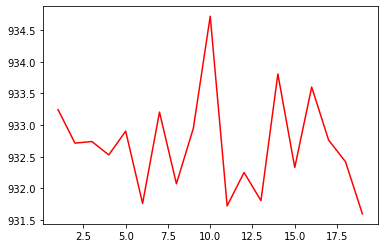

In [41]:
sse_min = min(history_sse)
neuronas = history_sse.index(sse_min)+1
print("Neuronas para usar en el modelo", neuronas)
plt.plot([i for i in range(1, 20)],history_sse, color = 'red')

# Validación


In [0]:
def cross_val(train_index, test_index,X,y):

    x_scale = scaler.transform(X[variables])
    y_scale = scaler.transform(y)
    
    X_train = x_scale[train_index, :]
    y_train = y_scale[train_index]
    X_test = x_scale[test_index, :]
    y_test = y_scale[test]

    model = tf.keras.Sequential()

    # Capa oculta con h neuronas
    model.add(tf.keras.layers.Dense(5, 
                                    activation = tf.nn.sigmoid,
                                    input_shape = (X_train.shape[1], )))
    # Capa de salida
    model.add(tf.keras.layers.Dense(1, 
                                    activation = tf.nn.sigmoid))

    # Optimizador
    # optimizer = tf.train.AdamOptimizer(learning_rate = 0.01)

    ## 
    model.compile(loss = 'mse',
                    metrics =['mse'])

    mf = model.fit(X_train, y_train, epochs = 1000, verbose = 0)

    y_pred = [u[0] for u in model.predict(X_test).tolist()]

    sse = np.sum(np.square(np.array(y_pred) - np.array(y_test)))

    return sse

from sklearn.model_selection import KFold

kf = KFold(n_splits=4)                       
cross_results = []

for train, test in kf.split(X):
    cross_results.append(cross_val(train, test, X, y))




In [50]:
resultado_cross_val = sum(cross_results)/ len(cross_results)
print("El resultado del cross Validation es: ", resultado_cross_val)

El resultado del cross Validation es:  712.5420464080019
